# Imports

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow import keras
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
tf.keras.backend.clear_session()

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imshow

import mlflow
import mlflow.tensorflow
from mlflow import MlflowClient

import pandas as pd
import numpy as np
from functools import partial
import json
import glob
import datetime
import re
import shutil




Segmentation Models: using `tf.keras` framework.


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect the TPU
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print("TPU initialized")
# except ValueError:
#     print("TPU not available")

2.16.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Init Folder Setup

- create save_model/visualization/version folder
- set version/week

In [3]:
VERSION = 'V04'
SAVE_MODEL_DIR = "../saved_models/"
SAVE_VIZ_DIR = "../Visualizations/"
WEEK=4
NUM_TEST = 60

directories = [SAVE_MODEL_DIR, SAVE_VIZ_DIR]
for dir_path in directories:
    version_dir = os.path.join(dir_path, VERSION)
    if not os.path.exists(version_dir):
        try:
            os.makedirs(version_dir)
            print(f"Created directory: {version_dir}")
            if dir_path == SAVE_VIZ_DIR:
                os.makedirs(os.path.join(version_dir,"test_overlay"))
        except PermissionError:
            print(f"Permission denied: Cannot create directory {version_dir}")
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"Directory already exists: {version_dir}")

Directory already exists: ../saved_models/V04
Directory already exists: ../Visualizations/V04


# Image Preparation/Preprocessing

## Helper Functions

In [4]:
def create_lookup_table(image):
    # image is an m x n x 3 tensor representing an RGB image
    # Convert the image to float32
    image = tf.cast(image, tf.float32)
    # Convert the RGB tuples to integers
    int_image = tf.cast(tf.tensordot(image, [65536.0, 256.0, 1.0], axes=1), tf.int64)
    # Find the unique integer values in the image
    unique_ints = tf.unique(tf.reshape(int_image, (-1)))[0]
    # Create a lookup table to map the integer values in int_image to their corresponding encoded values
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=unique_ints,
            values=tf.one_hot(tf.range(tf.size(unique_ints)), depth=tf.size(unique_ints)),
            key_dtype=tf.int64,
            value_dtype=tf.float32
        ),
        default_value=tf.zeros(tf.size(unique_ints), dtype=tf.float32)
    )
    return table

def encode_rgb(mask, palette):
    # Create a class map for each color in the palette
    semantic_map = []
    for color in palette:
        class_map = tf.reduce_all(tf.equal(mask, color), axis=-1)
        semantic_map.append(class_map)

    # Stack the class maps to create a one-hot encoded semantic map
    semantic_map = tf.stack(semantic_map, axis=-1)
    semantic_map = tf.cast(semantic_map, tf.float32)
    return semantic_map

def encode_binary_class(mask, class_idx):
    """
    Extract the binary mask for a specific class (target color) from the one-hot encoded mask.
    class_idx: The index of the class in the one-hot mask (e.g., 0 for red, 1 for green, 2 for blue).
    """
    # Select the channel corresponding to the target class
    binary_mask = mask[..., class_idx]
    
    # Return the binary mask (already 0/1 values)
    binary_mask = tf.expand_dims(binary_mask, axis=-1)

    return binary_mask

@tf.function
def extract_AV_mask(img, threshold =0):
    # split the image into rgb
    R = img[:, :, 0]
    B = img[:, :, 2]
    diff = R - B

    # create masks for arteries and veins
    artery_mask = tf.greater(diff, threshold)
    vein_mask = tf.less(diff, -threshold)
    ves_mask = tf.logical_or(artery_mask, vein_mask)

    # create an empty rgb image
    height, width = tf.shape(artery_mask)[0], tf.shape(artery_mask)[1]
    av_mask = tf.zeros((height, width, 3), dtype=tf.float32)


    artery_indices = tf.where(artery_mask)
    vein_indices = tf.where(vein_mask)
    overlap_indices = tf.where(tf.logical_and(artery_mask, vein_mask))

    artery_updates = tf.repeat([[1.0, 0.0, 0.0]], tf.shape(artery_indices)[0], axis=0)  # Red
    vein_updates = tf.repeat([[0.0, 0.0, 1.0]], tf.shape(vein_indices)[0], axis=0)      # Blue
    overlap_updates = tf.repeat([[0.0, 1.0, 0.0]], tf.shape(overlap_indices)[0], axis=0)  # Green

    av_mask = tf.tensor_scatter_nd_update(av_mask, artery_indices, artery_updates)
    av_mask = tf.tensor_scatter_nd_update(av_mask, vein_indices, vein_updates)
    av_mask = tf.tensor_scatter_nd_update(av_mask, overlap_indices, overlap_updates)

    return artery_mask, vein_mask, ves_mask, av_mask

@tf.function
def crop_and_pad_to_square(image):
    # convert the image to grayscale 
    gray = tf.image.rgb_to_grayscale(image)
    gray_float = tf.cast(gray, tf.float32)
    gray_uint8 = tf.cast(gray_float * 255.0, tf.uint8)

    # separate the circle from the background
    binary_mask = tf.where(gray_uint8 > 25, 1.0, 0.0)  # Use a threshold of 25 for uint8

    # find the non-zero elements 
    non_zero_indices = tf.where(binary_mask[..., 0] > 0)
    
    # Get the bounding box 
    top_left = tf.reduce_min(non_zero_indices, axis=0)
    bottom_right = tf.reduce_max(non_zero_indices, axis=0)
    
    # Crop the image to the bounding box
    cropped_image = image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1], :]
    cropped_height = tf.cast(bottom_right[0] - top_left[0], tf.int32)
    cropped_width = tf.cast(bottom_right[1] - top_left[1], tf.int32)
    
    if cropped_width > cropped_height:
        padded_image = tf.image.resize_with_crop_or_pad(cropped_image, cropped_width, cropped_width)
    elif cropped_height > cropped_width:
        padded_image = tf.image.resize_with_crop_or_pad(cropped_image, cropped_height, cropped_height)
    else:
        padded_image = cropped_image  # already square

    return padded_image


@tf.function
def normalize_image(image):
    """
    Check if the image is already in the range [0, 1].
    If the image has pixel values in the range [0, 255], normalize it to [0, 1].
    """
    
    return tf.cond(tf.reduce_max(image) > 1.0,true_fn=lambda: image/255.0,false_fn= lambda:image)

@tf.function
def process_path(image_path, vessel_path, av_path):
    '''
    Load and preprocess the RITE data.
    img: Decode and preprocess the input image (RGB).
    ves: Decode and preprocess the vessel image (grayscale).
    av: Decode and preprocess the AV image (RGB).
    '''

    # Decode the main image
    img = tf.io.read_file(image_path)
    img_extension = tf.strings.split(image_path, sep=".")[-1] 
    # print(img_extension)
    # print("hello1")
    # Conditionally decode based on the file extension
    img = tf.cond(
        tf.equal(img_extension, "tif"),
        lambda: tfio.experimental.image.decode_tiff(img)[..., :3],
        lambda: tf.cond(
            tf.equal(img_extension, "jpeg"),
            lambda: tf.image.decode_jpeg(img, channels=3),
            lambda: tf.image.decode_png(img, channels=3)
        )
    )
    
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    
    # Decode the vessel image
    ves = tf.io.read_file(vessel_path)
    ves_extension = tf.strings.split(vessel_path, sep=".")[-1] 

    ves = tf.cond(
        tf.equal(ves_extension, "tif"),
        lambda: tfio.experimental.image.decode_tiff(ves)[..., :1],
        lambda: tf.cond(
            tf.equal(ves_extension, "jpeg"),
            lambda: tf.image.decode_jpeg(ves, channels=1),
            lambda: tf.image.decode_png(ves, channels=1)
        )
    )
    ves = tf.image.convert_image_dtype(ves, dtype=tf.float32)
    
    

    # Decode the AV image
    av = tf.io.read_file(av_path)
    av_extension = tf.strings.split(av_path, sep=".")[-1]

    av = tf.cond(
        tf.equal(av_extension, "tif"),
        lambda: tfio.experimental.image.decode_tiff(av)[...,:3 ],
        lambda: tf.cond(
            tf.equal(av_extension, "jpeg"),
            lambda: tf.image.decode_jpeg(av, channels=3),
            lambda: tf.image.decode_png(av, channels=3)
        )
    )

    av = tf.image.convert_image_dtype(av, dtype=tf.float32)

    # Resize 
    img = tf.image.resize(img, (512, 512), method='nearest')
    ves = tf.image.resize(ves, (512, 512), method='nearest')
    av = tf.image.resize(av, (512, 512), method='nearest')

    # Normalize 
    img = normalize_image(img)
    ves = normalize_image(ves)
    av = normalize_image(av)

    artery_mask, vein_mask, ves_mask, av_mask= extract_AV_mask(av)

    ves_mask = tf.cast(ves_mask, tf.float32)
    av_mask = tf.cast(av_mask, tf.float32)
    artery_mask = tf.cast(artery_mask, tf.float32)
    vein_mask =  tf.cast(vein_mask, tf.float32)

    ves_mask = tf.expand_dims(ves_mask, axis=-1)
    artery_mask = tf.expand_dims(artery_mask, axis=-1)
    vein_mask = tf.expand_dims(vein_mask, axis=-1)

    # Concatenate img and ves along the last axis
    img_concat = tf.concat([img, ves], axis=-1)
    av_concat = tf.concat([artery_mask,vein_mask], axis=-1)

    return img_concat, av_concat

@tf.function
def process_five_train(image_path, vessel_path, av_path):
    # read images 
    img = tf.io.read_file(image_path)
    ves = tf.io.read_file(vessel_path)
    av = tf.io.read_file(av_path)
    
    # decode images (assume png)
    img = tf.image.decode_png(img, channels=3)
    ves = tf.image.decode_png(ves, channels=1)
    av = tf.image.decode_png(av, channels=3)

    # covert dtype
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    ves = tf.image.convert_image_dtype(ves, dtype=tf.float32)
    av = tf.image.convert_image_dtype(av, dtype=tf.float32)

    # Resize 
    img = tf.image.resize(img, (512, 512), method='nearest')
    ves = tf.image.resize(ves, (512, 512), method='nearest')
    av = tf.image.resize(av, (512, 512), method='nearest')

    # Normalize 
    img = normalize_image(img)
    ves = normalize_image(ves)
    av = normalize_image(av)


    # comment for differences
    artery_mask, vein_mask, ves_mask, av_mask= extract_AV_mask(av)

    ves_mask = tf.cast(ves_mask, tf.float32)
    av_mask = tf.cast(av_mask, tf.float32)
    artery_mask = tf.cast(artery_mask, tf.float32)
    vein_mask =  tf.cast(vein_mask, tf.float32)

    artery_mask = tf.expand_dims(artery_mask, axis=-1)
    vein_mask = tf.expand_dims(vein_mask, axis=-1)
    ves_mask = tf.expand_dims(ves_mask, axis=-1)

    img_concat = tf.concat([img,ves_mask],axis = -1)
    av_concat  = tf.concat([artery_mask,vein_mask],axis = -1)


    return img_concat, av_concat


@tf.function
def process_pac_train(image_path, av_path):
    # read images 
    img = tf.io.read_file(image_path)
    av = tf.io.read_file(av_path)
    
    # decode images (assume png)
    img = tf.image.decode_png(img, channels=3)
    av = tf.image.decode_png(av, channels=3)

    

    # covert dtype
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    av = tf.image.convert_image_dtype(av, dtype=tf.float32)
    
    img = crop_and_pad_to_square(img)
    
    # Resize 
    img = tf.image.resize(img, (512, 512), method='nearest')
    av = tf.image.resize(av, (512, 512), method='nearest')

    # Normalize 
    img = normalize_image(img)
    av = normalize_image(av)

    artery_mask, vein_mask, ves_mask, av_mask= extract_AV_mask(av, threshold=0.1)

    ves_mask = tf.cast(ves_mask, tf.float32)
    av_mask = tf.cast(av_mask, tf.float32)
    artery_mask = tf.cast(artery_mask, tf.float32)
    vein_mask =  tf.cast(vein_mask, tf.float32)

    ves_mask = tf.expand_dims(ves_mask, axis=-1)
    artery_mask = tf.expand_dims(artery_mask, axis=-1)
    vein_mask = tf.expand_dims(vein_mask, axis=-1)

    img_concat = tf.concat([img,ves_mask],axis = -1)
    av_concat  = tf.concat([artery_mask,vein_mask],axis = -1)
    
    return img_concat, av_concat




## RITE

### File Path Setup

In [5]:
DATASET_DIR = "../data/RFI_Dataset/RITE Dataset"

TRAIN_DATA_DIR = os.path.join(DATASET_DIR, "training", "images")
TRAIN_VESSEL_DIR = os.path.join(DATASET_DIR, "training", "vessel")
TRAIN_AV_DIR = os.path.join(DATASET_DIR, "training", "av")
TEST_DATA_DIR = os.path.join(DATASET_DIR, "test", "images")
TEST_VESSEL_DIR = os.path.join(DATASET_DIR, "test", "vessel")
TEST_AV_DIR = os.path.join(DATASET_DIR, "test", "av")

train_image_list = sorted(os.listdir(TRAIN_DATA_DIR))
#train_image_list = [x for x in train_image_list if x[-4:] == ".png"]
train_vessel_list = sorted(os.listdir(TRAIN_VESSEL_DIR))
train_av_list = sorted(os.listdir(TRAIN_AV_DIR))

test_image_list = sorted(os.listdir(TEST_DATA_DIR))
test_vessel_list = sorted(os.listdir(TEST_VESSEL_DIR))
test_av_list = sorted(os.listdir(TEST_AV_DIR))

train_image_list = [os.path.join(TRAIN_DATA_DIR, x) for x in train_image_list]
train_vessel_list = [os.path.join(TRAIN_VESSEL_DIR, x) for x in train_vessel_list]
train_av_list = [os.path.join(TRAIN_AV_DIR, x) for x in train_av_list]

test_image_list = [os.path.join(TEST_DATA_DIR, x) for x in test_image_list]
test_vessel_list = [os.path.join(TEST_VESSEL_DIR, x) for x in test_vessel_list]
test_av_list = [os.path.join(TEST_AV_DIR, x) for x in test_av_list]

# Construct the original training & testing datasets
train_image_filenames = tf.constant(train_image_list)
train_vessel_filenames = tf.constant(train_vessel_list)
train_av_filenames = tf.constant(train_av_list)

test_image_filenames = tf.constant(test_image_list)
test_vessel_filenames = tf.constant(test_vessel_list)
test_av_filenames = tf.constant(test_av_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_vessel_filenames, train_av_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_vessel_filenames, test_av_filenames))


### Apply Preprocessing

In [6]:
train_dataset = train_dataset.map(process_path)
test_dataset = test_dataset.map(process_path)

### Image after Preprocessing

- Resize
- Normalization
- Concatenate input with vessels

Concatenated Image shape (img): (512, 512, 4)
AV Segmentation shape (av): (512, 512, 2)


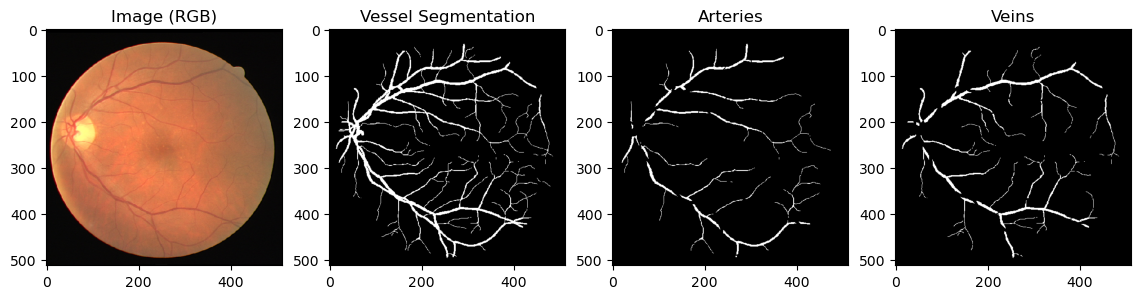

2024-10-15 19:25:59.414447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:


for img,av in train_dataset.take(1):
    print("Concatenated Image shape (img):", img.shape)  # (512, 512, 4)
    print("AV Segmentation shape (av):", av.shape) # (512, 512, 3)

    rgb_img = img[:, :, :3]  # Shape: (512, 512, 3)
    vessel_segmentation = img[:, :, 3]  # Shape: (512, 512), single channel

    fig, arr = plt.subplots(1, 4, figsize=(14, 10))
    arr[0].imshow(rgb_img)
    arr[0].set_title('Image (RGB)')

    arr[1].imshow(vessel_segmentation, cmap='gray')
    arr[1].set_title('Vessel Segmentation')


    arr[2].imshow(av[:, :, 0], cmap='gray')
    arr[2].set_title('Arteries')

    arr[3].imshow(av[:, :, 1], cmap='gray')
    arr[3].set_title('Veins')



    plt.show()


## FIVES

### File Path Setup

In [8]:
# Define the directories
FIVE_DIR = '../data/RFI_Dataset/FIVES Dataset/'
IMG_AUG_DIR = os.path.join(FIVE_DIR, "train", "Original")
VES_AUG_DIR = os.path.join(FIVE_DIR, "train", "Ground truth")
AV_AUG_DIR = os.path.join(FIVE_DIR, "train", "AV_prediction")


# List all files in each directory
img_aug_list = sorted(os.listdir(IMG_AUG_DIR))
ves_aug_list = sorted(os.listdir(VES_AUG_DIR))
av_aug_list = sorted(os.listdir(AV_AUG_DIR))


img_aug_set = set(img_aug_list)
ves_aug_set = set(ves_aug_list)
av_aug_set = set(av_aug_list)


common_files = img_aug_set & ves_aug_set & av_aug_set



pattern = re.compile(r'^\d{1,3}_[ADGN]\.png$')

# Filter files 
filtered_common_files = [f for f in common_files if pattern.match(f)]

# Generate paths
img_aug_list = [os.path.join(IMG_AUG_DIR, f) for f in filtered_common_files]
ves_aug_list = [os.path.join(VES_AUG_DIR, f) for f in filtered_common_files]
av_aug_list = [os.path.join(AV_AUG_DIR, f) for f in filtered_common_files]

# Convert them into TensorFlow constants
aug_img_filenames = tf.constant(img_aug_list)
aug_ves_filenames = tf.constant(ves_aug_list)
aug_av_filenames = tf.constant(av_aug_list)

# Create the TensorFlow dataset
five_dataset = tf.data.Dataset.from_tensor_slices((aug_img_filenames, aug_ves_filenames, aug_av_filenames))

### Apply Preprocessing

In [9]:
five_dataset = five_dataset.map(process_five_train)

### Image after Preprocessing

- Resize
- Normalization

Concatenated Image shape (img): (512, 512, 4)
AV Segmentation shape (av): (512, 512, 2)


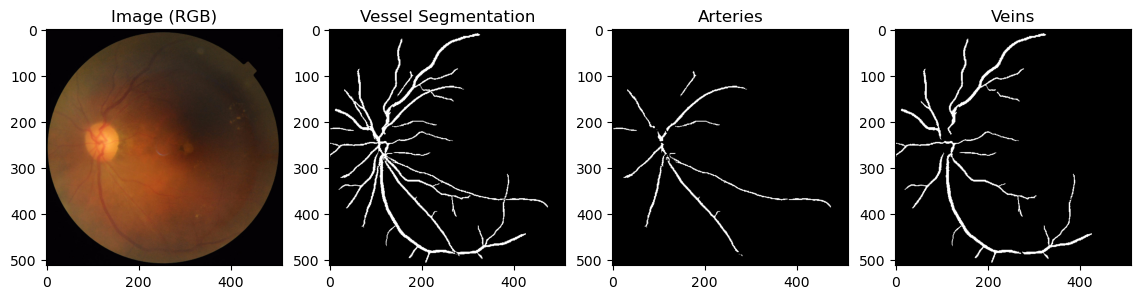

2024-10-15 19:25:59.957022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:


for img,av in five_dataset.take(1):
    print("Concatenated Image shape (img):", img.shape)  # (512, 512, 4)
    print("AV Segmentation shape (av):", av.shape) # (512, 512, 3)

    rgb_img = img[:, :, :3]  # Shape: (512, 512, 3)
    vessel_segmentation = img[:, :, 3]  # Shape: (512, 512), single channel

    fig, arr = plt.subplots(1, 4, figsize=(14, 10))
    arr[0].imshow(rgb_img)
    arr[0].set_title('Image (RGB)')

    arr[1].imshow(vessel_segmentation, cmap='gray')
    arr[1].set_title('Vessel Segmentation')


    arr[2].imshow(av[:, :, 0], cmap='gray')
    arr[2].set_title('Arteries')

    arr[3].imshow(av[:, :, 1], cmap='gray')
    arr[3].set_title('Veins')



    plt.show()

### take sample as test and combine train

In [11]:
extra_test_data = five_dataset.take(NUM_TEST)
five_dataset = five_dataset.skip(NUM_TEST)
train_dataset = train_dataset.concatenate(five_dataset)
test_dataset = test_dataset.concatenate(extra_test_data)


In [12]:
fives_test_img = img_aug_list[:NUM_TEST]
fives_test_ves = ves_aug_list[:NUM_TEST]
fives_test_av = av_aug_list[:NUM_TEST]

test_image_list.extend(fives_test_img)
test_vessel_list.extend(fives_test_ves)
test_av_list.extend(fives_test_av)

In [13]:
tf.data.experimental.cardinality(train_dataset).numpy(), tf.data.experimental.cardinality(test_dataset).numpy()

(527, 80)

## RMHAS

### File Path Setup

In [14]:
EYEPACS_DIR = '../data/RFI_Dataset/EYEPACS/'
IMG_AUG_LIST = []
AV_AUG_LIST = []

# Loop over all version subdirectories
for version in os.listdir(EYEPACS_DIR):
    version_dir = os.path.join(EYEPACS_DIR, version)
    
    # Check if the version directory contains the 'train' subdirectory
    train_dir = os.path.join(version_dir, "train")
    img_aug_dir = os.path.join(train_dir, "Original")
    av_aug_dir = os.path.join(train_dir, "AV_prediction")
    
    # Ensure both Original and AV_prediction directories exist
    if os.path.isdir(img_aug_dir) and os.path.isdir(av_aug_dir):
        
        # Get the list of .png files in each directory (excluding hidden files)
        img_files = sorted([f for f in os.listdir(img_aug_dir) if f.endswith('.png') and not f.startswith('.')])
        av_files = sorted([f for f in os.listdir(av_aug_dir) if f.endswith('.png') and not f.startswith('.')])
        print(f"VERSION :{version}")
        # Convert lists to sets for finding common files
        img_set = set(img_files)
        av_set = set(av_files)
        print(len(img_set))
        print(len(av_set))
        
        # Find common files in both directories
        common_files = img_set & av_set
        
        # Append the full path for common files to the respective lists
        for filename in common_files:
            IMG_AUG_LIST.append(os.path.join(img_aug_dir, filename))
            AV_AUG_LIST.append(os.path.join(av_aug_dir, filename))

# Convert lists to TensorFlow constants
pac_img_filenames = tf.constant(IMG_AUG_LIST)
pac_av_filenames = tf.constant(AV_AUG_LIST)

# Ensure matched pairs
if len(pac_img_filenames) != len(pac_av_filenames):
    print("Mismatch between image files and AV prediction files.")
else:
    print(f"Found {len(pac_img_filenames)} matching pairs of images and AV predictions.")

# Create the TensorFlow dataset
pac_dataset = tf.data.Dataset.from_tensor_slices((pac_img_filenames, pac_av_filenames))

VERSION :V03
1124
1124
VERSION :V02
383
383
Found 1507 matching pairs of images and AV predictions.


### Apply Preprocessing

In [15]:
pac_dataset = pac_dataset.map(process_pac_train)

### Image after Preprocessing

Concatenated Image shape (img): (512, 512, 4)
AV Segmentation shape (av): (512, 512, 2)


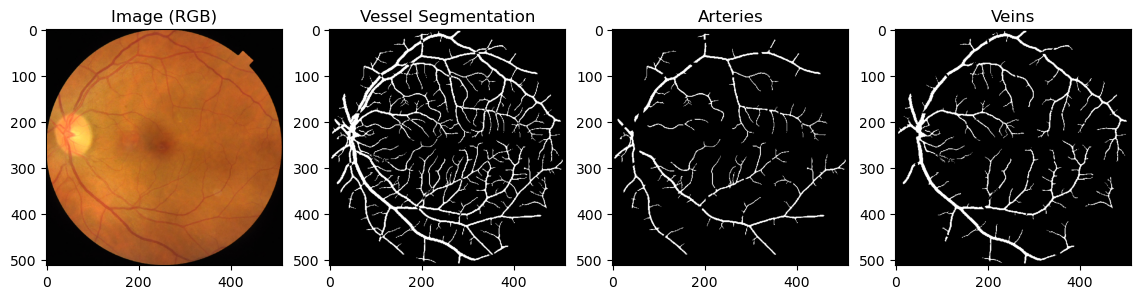

2024-10-15 19:26:00.728039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:


for img,av in pac_dataset.take(1):
    print("Concatenated Image shape (img):", img.shape)  # (512, 512, 4)
    print("AV Segmentation shape (av):", av.shape) # (512, 512, 3)

    rgb_img = img[:, :, :3]  # Shape: (512, 512, 3)
    vessel_segmentation = img[:, :, 3]  # Shape: (512, 512), single channel

    fig, arr = plt.subplots(1, 4, figsize=(14, 10))
    arr[0].imshow(rgb_img)
    arr[0].set_title('Image (RGB)')

    arr[1].imshow(vessel_segmentation, cmap='gray')
    arr[1].set_title('Vessel Segmentation')


    arr[2].imshow(av[:, :, 0], cmap='gray')
    arr[2].set_title('Arteries')

    arr[3].imshow(av[:, :, 1], cmap='gray')
    arr[3].set_title('Veins')



    plt.show()

### Combine train

In [17]:
train_dataset = train_dataset.concatenate(pac_dataset)

In [18]:
tf.data.experimental.cardinality(train_dataset).numpy(), tf.data.experimental.cardinality(test_dataset).numpy()

(2034, 80)

# Model

In [19]:
EPOCHS = 100
BUFFER_SIZE = 4
BATCH_SIZE = 16
VALIDATION_RATIO = 0.1

In [20]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def iou_score(y_true, y_pred):
    # Ensure that y_pred is a binary mask (0 or 1)
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    # Intersection
    intersection = K.sum(y_true * y_pred)
    
    # Union
    union = K.sum(K.clip(y_true + y_pred, 0, 1))
    
    # calculation
    iou = intersection / (union + K.epsilon())  # Add epsilon to avoid division by zero
    
    return iou

## Arteries (Red)

### Set Up

In [21]:
backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="./keras_backups_arteries" 
)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath= os.path.join(SAVE_MODEL_DIR, VERSION, "arteries_best_pretrained_unet_av_100_epochs.keras"),     
    monitor='val_iou_score',               
    save_best_only=True,                   
    mode='auto',                           
    verbose=0                              
)
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_iou_score',               
    patience=5,                            
    mode='auto',                          
    restore_best_weights=True,            
    verbose=0
)


callbacks = [backup_callback, checkpoint_callback, early_stopping_callback]

In [22]:
red_train_dataset = train_dataset.map(lambda img, av: (img[:,:,:3], tf.expand_dims(av[:,:,0], axis=-1)))
red_test_dataset = test_dataset.map(lambda img, av: (img[:,:,:3], tf.expand_dims(av[:,:,0], axis=-1)))


In [ ]:


dataset_size = tf.data.experimental.cardinality(red_train_dataset).numpy()
validation_size = int(VALIDATION_RATIO * dataset_size)
train_size = dataset_size - validation_size

print(f"train_size: {train_size}, validation size: {validation_size}")
red_train_dataset = red_train_dataset.shuffle(buffer_size=BUFFER_SIZE)
validation_dataset = red_train_dataset.take(validation_size)
red_train_dataset = red_train_dataset.skip(validation_size)
red_train_dataset = red_train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
red_validation_dataset = validation_dataset.cache().batch(BATCH_SIZE)

### Training

In [24]:
pretrained_base_model = sm.Unet(encoder_weights='imagenet', classes=1)  

# Input shape (for 4-channel input) and adjust it to 3 channels for the pretrained model
inp = keras.Input(shape=(None, None, 3))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)  # Map 4-channel input to 3-channel input
out = pretrained_base_model(l1)

arteries_model = keras.Model(inp, out, name=pretrained_base_model.name)
arteries_model.compile(
    optimizer='Adam',
    loss=keras.losses.binary_crossentropy,  # Binary classification loss
    metrics=[
        f1_score,               # Custom F1 Score
        iou_score,              # Custom IoU Score
        keras.metrics.AUC(),     # AUC Metric
        keras.metrics.BinaryAccuracy()  # Accuracy for binary classification
    ]
)

red_history = arteries_model.fit(red_train_dataset, epochs=EPOCHS, callbacks=callbacks, validation_data=red_validation_dataset)

In [24]:
model_perform = pd.DataFrame(red_history.history)
saved_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "arteries_history.json")
model_perform.to_json(saved_model_path, orient='records', indent=4)


In [27]:
# arteries_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "arteries_pretrained_unet_av_100_epochs.keras")
# arteries_model.save(arteries_model_path)

## Veins (Blue)

In [25]:
backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="./keras_backups_veins" 
)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath= os.path.join(SAVE_MODEL_DIR, VERSION, "veins_best_pretrained_unet_av_100_epochs.keras"),     
    monitor='val_iou_score',               
    save_best_only=True,                   
    mode='auto',                           
    verbose=0                              
)
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_iou_score',               
    patience=5,                            
    mode='auto',                          
    restore_best_weights=True,            
    verbose=0
)

# Combine all callbacks into a list
callbacks = [backup_callback, checkpoint_callback, early_stopping_callback]

In [26]:
blue_train_dataset = train_dataset.map(lambda img, av: (img[:, :, :3], tf.expand_dims(av[:,:,1], axis=-1)))
blue_test_dataset = test_dataset.map(lambda img, av: (img[:, :, :3], tf.expand_dims(av[:,:,1], axis=-1)))

In [ ]:


dataset_size = tf.data.experimental.cardinality(blue_train_dataset).numpy()
validation_size = int(VALIDATION_RATIO * dataset_size)
train_size = dataset_size - validation_size

print(f"train_size: {train_size}, validation size: {validation_size}")
blue_train_dataset = blue_train_dataset.shuffle(buffer_size=BUFFER_SIZE)
validation_dataset = blue_train_dataset.take(validation_size)
blue_train_dataset = blue_train_dataset.skip(validation_size)
blue_train_dataset = blue_train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
blue_validation_dataset = validation_dataset.cache().batch(BATCH_SIZE)

In [ ]:
pretrained_base_model = sm.Unet(encoder_weights='imagenet', classes=1)  

# Input shape (for 4-channel input) and adjust it to 3 channels for the pretrained model
inp = keras.Input(shape=(None, None, 3))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)  # Map 4-channel input to 3-channel input
out = pretrained_base_model(l1)

veins_model = keras.Model(inp, out, name=pretrained_base_model.name)
veins_model.compile(
    optimizer='Adam',
    loss=keras.losses.binary_crossentropy,  # Binary classification loss
    metrics=[
        f1_score,               # Custom F1 Score
        iou_score,              # Custom IoU Score
        keras.metrics.AUC(),     # AUC Metric
        keras.metrics.BinaryAccuracy()  # Accuracy for binary classification
    ]
)

blue_history = veins_model.fit(blue_train_dataset, epochs=EPOCHS, callbacks=callbacks, validation_data=blue_validation_dataset)

In [29]:
model_perform = pd.DataFrame(blue_history.history)
saved_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "veins_history.json")
model_perform.to_json(saved_model_path, orient='records', indent=4)

In [32]:
# veins_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "veins_pretrained_unet_av_100_epochs.keras")
# veins_model.save(veins_model_path)

# Result

## Helper Functions

In [21]:
def overlay(rgb_img, mask, color, alpha=0.9):
    """
    Overlay a mask onto the RGB image.

    """

    
    if isinstance(rgb_img, tf.Tensor):
        rgb_img = rgb_img.numpy()  
    if isinstance(mask, tf.Tensor):
        mask = mask.numpy()  

    # Convert mask to binary (0 or 1)
    mask = np.clip(mask, 0, 1)

    if rgb_img.max() <= 1.0:  # If the image is normalized, scale it back
        rgb_img = (rgb_img * 255).astype(np.uint8)
    else:
        rgb_img = rgb_img.astype(np.uint8)

    overlay_img = rgb_img.copy()

    if color == 'red':
        overlay_img[:, :, 0] = np.where(mask == 1, 255, overlay_img[:, :, 0]) 
    elif color == 'green':
        overlay_img[:, :, 1] = np.where(mask == 1, 255, overlay_img[:, :, 1])  
    elif color == 'blue':
        overlay_img[:, :, 2] = np.where(mask == 1, 255, overlay_img[:, :, 2]) 
    else:
        raise ValueError("Color must be 'red', 'green', or 'blue'.")

    blended_img = (alpha * overlay_img + (1 - alpha) * rgb_img).astype(np.uint8)
    
    return blended_img

def overlay_combined(rgb_img, art_mask, vein_mask, alpha=0.9):
    rgb_img = rgb_img.numpy()  
    art_mask = art_mask.numpy()
    vein_mask = vein_mask.numpy()
    
    # Ensure both masks are binary (0 or 1)
    art_mask = np.clip(art_mask, 0, 1)
    vein_mask = np.clip(vein_mask, 0, 1)


    if rgb_img.max() <= 1.0: 
        rgb_img = (rgb_img * 255).astype(np.uint8)
    else:
        rgb_img = rgb_img.astype(np.uint8)

    
    overlay_img = rgb_img.copy()

    # Overlay artery mask in red
    overlay_img[:, :, 0] = np.where(art_mask == 1, 255, overlay_img[:, :, 0])  # Modify red channel

    # Overlay vein mask in blue
    overlay_img[:, :, 2] = np.where(vein_mask == 1, 255, overlay_img[:, :, 2])  # Modify blue channel

    blended_img = (alpha * overlay_img + (1 - alpha) * rgb_img).astype(np.uint8)
    
    return blended_img

In [25]:

def plot_predictions(red_model, blue_model, data, file_paths, show=True, num=1):
    # Ensure file_paths and data are aligned
    file_paths = file_paths[:num]
    assert len(file_paths) >= num, "The number of file paths should match the number of examples in the dataset."

    idx = 0
    for input_img, input_av in data.take(num):
        file_name = os.path.splitext(os.path.basename(file_paths[idx]))[0]

        # expansion to (1, 512, 512, 4)
        input_img_with_batch = tf.expand_dims(input_img, axis=0)

        # prediction
        output_arteries = red_model.predict(input_img_with_batch)
        output_veins = blue_model.predict(input_img_with_batch)

        # Binarize the predictions
        output_art = np.where(output_arteries[0] > 0.5, 1, 0)
        output_vein = np.where(output_veins[0] > 0.5, 1, 0)

        # Extract image channels
        input_rgb = input_img[:, :, :3]
        # input_ves = input_img[:, :, 3]
        input_art = input_av[:, :, 0]
        input_vein = input_av[:, :, 1]

        input_ves_overlay = overlay_combined(input_rgb, input_art, input_vein)
        input_art_overlay = overlay(input_rgb, input_art, color='red')
        input_vein_overlay = overlay(input_rgb, input_vein, color='blue')
        output_art_overlay = overlay(input_rgb, output_art.squeeze(), color='red')
        output_vein_overlay = overlay(input_rgb, output_vein.squeeze(), color='blue')

        # Visualization code
        fig, arr = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 0.2})

        arr[0][0].imshow(input_rgb)  # Original RGB image
        arr[0][0].set_title('Original Image (RGB)', fontsize=16)
        arr[0][0].axis('off')

        arr[0][1].imshow(input_ves_overlay, cmap='gray')  # Vessel segmentation (4th channel)
        arr[0][1].set_title('Vessel Segmentation', fontsize=16)
        arr[0][1].axis('off')

        arr[1][0].imshow(input_art_overlay, cmap='gray')  # True Arteries
        arr[1][0].set_title('True Arteries', fontsize=16)
        arr[1][0].axis('off')

        arr[1][1].imshow(output_art_overlay, cmap='gray')  # Predicted Arteries
        arr[1][1].set_title('Predicted Arteries', fontsize=16)
        arr[1][1].axis('off')

        arr[2][0].imshow(input_vein_overlay, cmap='gray')  # True Veins
        arr[2][0].set_title('True Veins', fontsize=16)
        arr[2][0].axis('off')

        arr[2][1].imshow(output_vein_overlay, cmap='gray')  # Predicted Veins
        arr[2][1].set_title('Predicted Veins', fontsize=16)
        arr[2][1].axis('off')
        
        # Display or save
        if show:
            print(file_name)
            plt.tight_layout()
            plt.show()
        else:
            # Save the plot using the original file name
            save_filename = os.path.join(SAVE_VIZ_DIR, VERSION, "test_overlay", f"{file_name}.png")
            plt.tight_layout()
            plt.savefig(save_filename, dpi=300, bbox_inches='tight')
            plt.close()

        idx += 1
        

## Predict and save Image

In [26]:
test_num = tf.data.experimental.cardinality(test_dataset).numpy()

veins_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "veins_best_pretrained_unet_av_100_epochs.keras")
arteries_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "arteries_best_pretrained_unet_av_100_epochs.keras")

arteries_mdl = keras.models.load_model(arteries_model_path, custom_objects={'f1_score': f1_score, 'iou_score':iou_score})
veins_mdl = keras.models.load_model(veins_model_path, custom_objects={'f1_score': f1_score, 'iou_score':iou_score})

In [28]:
plot_predictions(arteries_mdl,veins_mdl, test_dataset.map(lambda img, av: (img[:,:,:3], av)), test_image_list,show=False, num=test_num)


I0000 00:00:1729045733.210847 2439699 service.cc:145] XLA service 0x35300e180 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729045733.211123 2439699 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-10-15 19:28:53.261789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729045733.721280 2439699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/var/folders/qt/pddm3t3951g42p57pf8yms780000gn/T/ipykernel_34840/1732728038.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2024-10-15 19:31:44.993222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training History

In [29]:
def plot_training_history(df, mode,save = False ):

    plt.figure(figsize=(12, 10))
    plt.suptitle(f'{mode.capitalize()} Model', fontsize=22, y=1.02)

    # Plot Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(df['binary_accuracy'], label='Train Accuracy')
    plt.plot(df['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy', fontsize = 20)
    plt.xlabel('Epoch', fontsize = 17)
    plt.ylabel('Accuracy', fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(3, 2, 2)
    plt.plot(df['loss'], label='Train Loss')
    plt.plot(df['val_loss'], label='Validation Loss')
    plt.title('Model Loss', fontsize = 20)
    plt.xlabel('Epoch', fontsize = 17)
    plt.ylabel('Loss', fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='upper right')

    # Plot f1-score
    plt.subplot(3, 2, 3)
    plt.plot(df['f1_score'], label='Train f1-score')
    plt.plot(df['val_f1_score'], label='Validation f1-score')
    plt.title('Model f1-score', fontsize = 20)
    plt.xlabel('Epoch', fontsize = 17)
    plt.ylabel('f1-score', fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='lower right')

    # Plot iou_score
    plt.subplot(3, 2, 4)
    plt.plot(df['iou_score'], label='Train iou_score')
    plt.plot(df['val_iou_score'], label='Validation iou_score')
    plt.title('Model iou_score', fontsize = 20)
    plt.xlabel('Epoch', fontsize = 17)
    plt.ylabel('iou_score', fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='lower right')

    # Plot AUC
    plt.subplot(3, 2, 5)
    plt.plot(df['auc'], label='Train AUC')
    plt.plot(df['val_auc'], label='Validation AUC')
    plt.title('Model AUC', fontsize = 20)
    plt.xlabel('Epoch', fontsize = 17)
    plt.ylabel('AUC', fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='lower right')

    if save:
        save_filename = os.path.join(SAVE_VIZ_DIR,VERSION, f'{mode}_training_history.png')
        plt.tight_layout()
        plt.savefig(save_filename, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.tight_layout()
        plt.show()

### Artery (Red)

In [30]:
fp = os.path.join(SAVE_MODEL_DIR, VERSION, "arteries_history.json")

arteries_history = pd.read_json(fp)
arteries_history.tail()

,auc,binary_accuracy,f1_score,iou_score,loss,val_auc,val_binary_accuracy,val_f1_score,val_iou_score,val_loss
31,0.951708,0.969370,0.503286,0.338589,0.083380,0.894222,0.964968,0.313485,0.186392,0.113433
32,0.953058,0.969605,0.509644,0.344178,0.082389,0.901301,0.964934,0.308789,0.183124,0.111315
33,0.954756,0.969932,0.518963,0.352486,0.081226,0.908615,0.965105,0.329278,0.197611,0.108519
34,0.955929,0.970067,0.523282,0.356393,0.080474,0.906845,0.965171,0.315560,0.187850,0.109820
35,0.956740,0.970306,0.527798,0.360618,0.079805,0.901890,0.965173,0.305266,0.180681,0.111802


In [31]:
plot_training_history(arteries_history,mode='arteries', save=True)

### Veins (Blue)

In [32]:
fp = os.path.join(SAVE_MODEL_DIR, VERSION, "veins_history.json")

veins_history = pd.read_json(fp)
veins_history = veins_history.rename({"auc_1":"auc","val_auc_1":"val_auc"},axis=1)
veins_history.tail()

,auc,binary_accuracy,f1_score,iou_score,loss,val_auc,val_binary_accuracy,val_f1_score,val_iou_score,val_loss
42,0.971836,0.969490,0.698287,0.538963,0.080995,0.941698,0.957400,0.379511,0.237291,0.115504
43,0.972334,0.969703,0.701506,0.542974,0.080380,0.940912,0.958220,0.413414,0.263288,0.113648
44,0.973113,0.970195,0.707023,0.549349,0.079163,0.940345,0.958558,0.395445,0.249069,0.116008
45,0.973849,0.970739,0.713275,0.557057,0.077783,0.938706,0.958408,0.389424,0.244704,0.117690
46,0.974745,0.970988,0.716530,0.561021,0.076820,0.937147,0.958402,0.377416,0.235510,0.120912


In [33]:
plot_training_history(veins_history,mode='veins', save=True)

## Improvement Metric (Week)

### Helper Functions

In [34]:
from sklearn.metrics import f1_score 

def store_metrics(model, data, idx, file_paths):
    # num of file paths match the data length
    assert len(file_paths) >= tf.data.experimental.cardinality(data).numpy(), "The number of file paths should match the number of examples in the dataset."
    
    f1_scores = np.array([])
    accs = np.array([])
    aucs = np.array([])
    ious = np.array([])
    filenames = []  


    for i, (input_img, input_av) in enumerate(data):
        input_img_with_batch = tf.expand_dims(input_img, axis=0)


        output = model.predict(input_img_with_batch)[0].squeeze().ravel()

    
        input = input_av[:, :, idx].numpy().ravel().astype(np.float32)
        
        f1_score_ = f1_score(input, output > 0.5)

        auc_metric = keras.metrics.AUC()
        auc_metric.update_state(input, output)
        auc = auc_metric.result().numpy()

        iou_metric = keras.metrics.MeanIoU(num_classes=2)
        iou_metric.update_state(input, output > 0.5)
        iou = iou_metric.result().numpy()

        acc_metric = keras.metrics.BinaryAccuracy()
        acc_metric.update_state(input, output)
        acc = acc_metric.result().numpy()

        f1_scores = np.append(f1_scores, f1_score_)
        accs = np.append(accs, acc)
        aucs = np.append(aucs, auc)
        ious = np.append(ious, iou)
        
        
        file_name = file_paths[i].split("/")[-1]
        filenames.append(file_name)

    df = pd.DataFrame({
        'Filename': filenames,
        'f1_score': f1_scores,
        'Accuracy': accs,
        'AUC': aucs,
        'IOU': ious
    })

    df.set_index('Filename', inplace=True)
    
    return df

def combine_csv_files(directory_path, start ):
    combined_df = pd.DataFrame()  
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.startswith(start):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

# plot
def plot_boxplot(ax, df, metric_name, title, size=23):
    ax.boxplot([df[df['week'] == week][metric_name] for week in sorted(df['week'].unique())], labels=sorted(df['week'].unique()))
    ax.set_title(title, fontsize=size)
    ax.set_xlabel("Week", fontsize=size-3)
    ax.set_ylabel(metric_name.capitalize(), fontsize=size-3)
    ax.tick_params(axis='both', which='major', labelsize=size-5)


### Arteries

In [36]:
df = store_metrics(arteries_mdl, test_dataset.map(lambda img, av: (img[:,:,:3], av)),0,test_image_list)
df['week'] = WEEK


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-10-15 19:42:38.865523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
fp = os.path.join(SAVE_MODEL_DIR,VERSION,"Arteries_weekly_metrics.csv")
df.to_csv(fp)

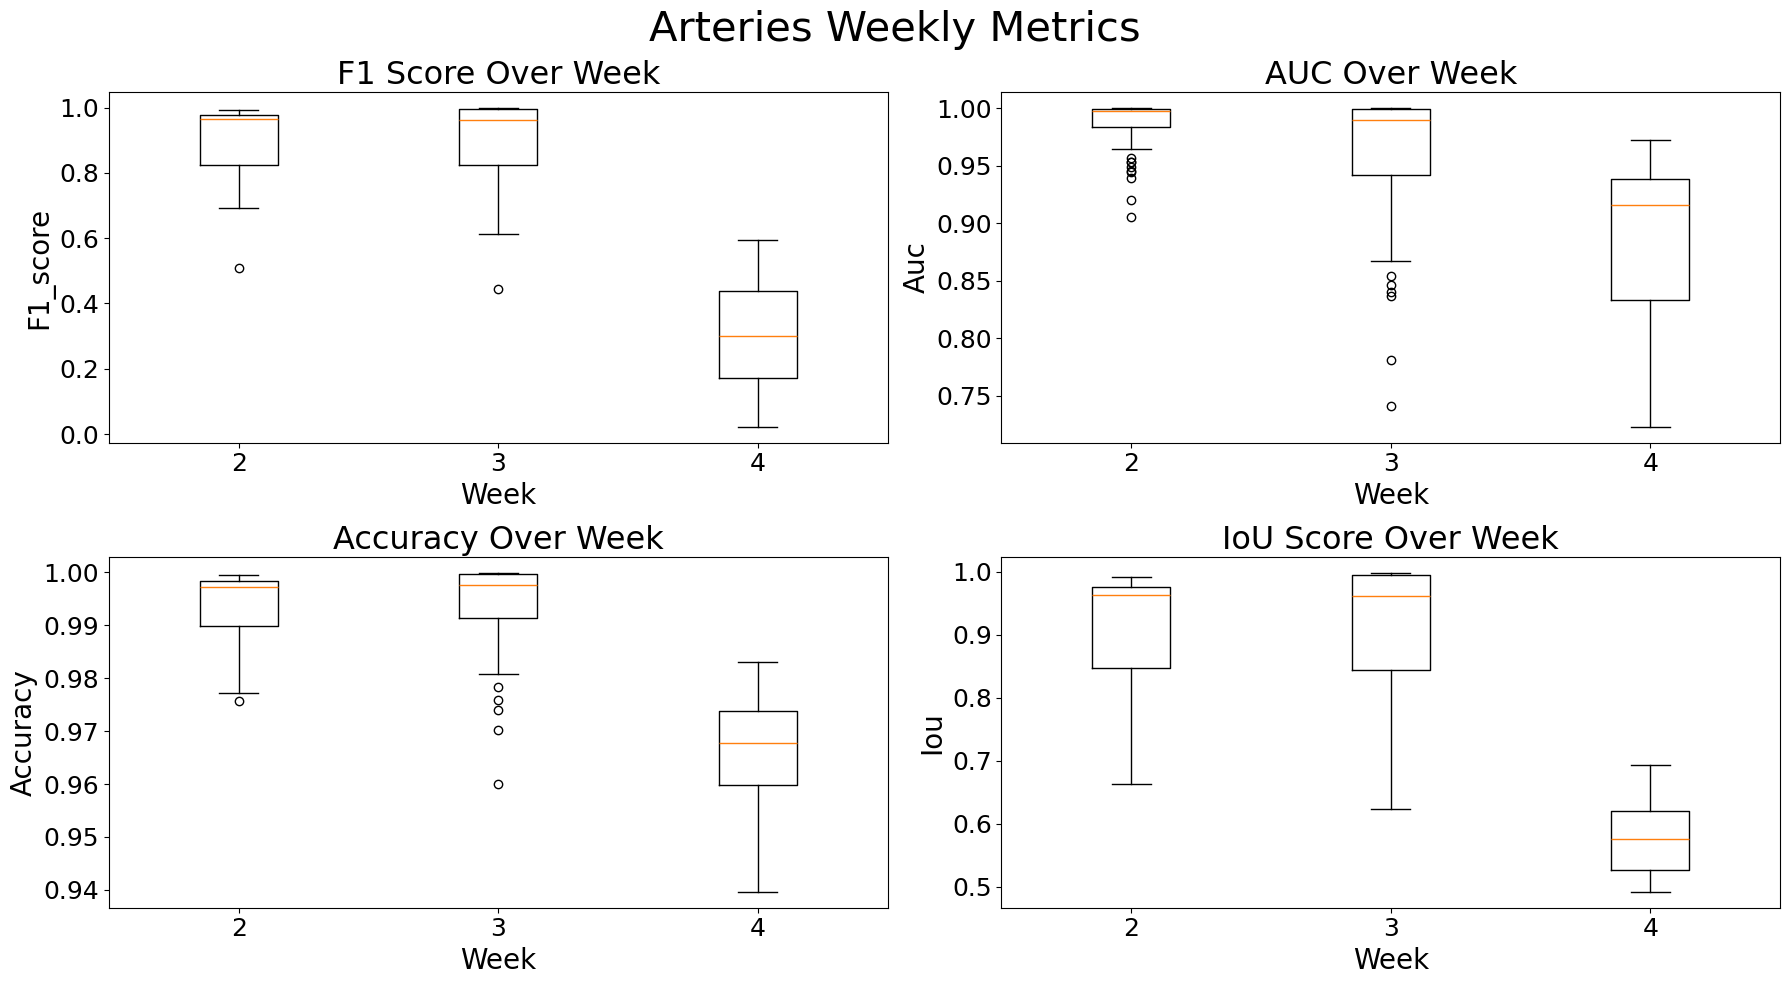

In [38]:

combined_df = combine_csv_files(SAVE_MODEL_DIR,"Arteries_weekly_metrics.csv")


fig, axes = plt.subplots(2, 2, figsize=(18, 10))

plot_boxplot(axes[0][0], combined_df, 'f1_score', 'F1 Score Over Week')
plot_boxplot(axes[0][1], combined_df, 'AUC', 'AUC Over Week')
plot_boxplot(axes[1][0], combined_df, 'Accuracy', 'Accuracy Over Week')
plot_boxplot(axes[1][1], combined_df, 'IOU', 'IoU Score Over Week')

plt.suptitle('Arteries Weekly Metrics', fontsize=30)
plt.tight_layout()

# Save and display 
save_metric_path = os.path.join(SAVE_VIZ_DIR,VERSION,"Arteries_weekly_metrics_over_time.png")
plt.savefig(save_metric_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

### Veins

In [40]:
df = store_metrics(veins_mdl, test_dataset.map(lambda img, av: (img[:,:,:3], av)),1,test_image_list)
df['week'] = WEEK

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-10-15 19:44:34.113780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
fp = os.path.join(SAVE_MODEL_DIR,VERSION,"Veins_weekly_metrics.csv")
df.to_csv(fp)

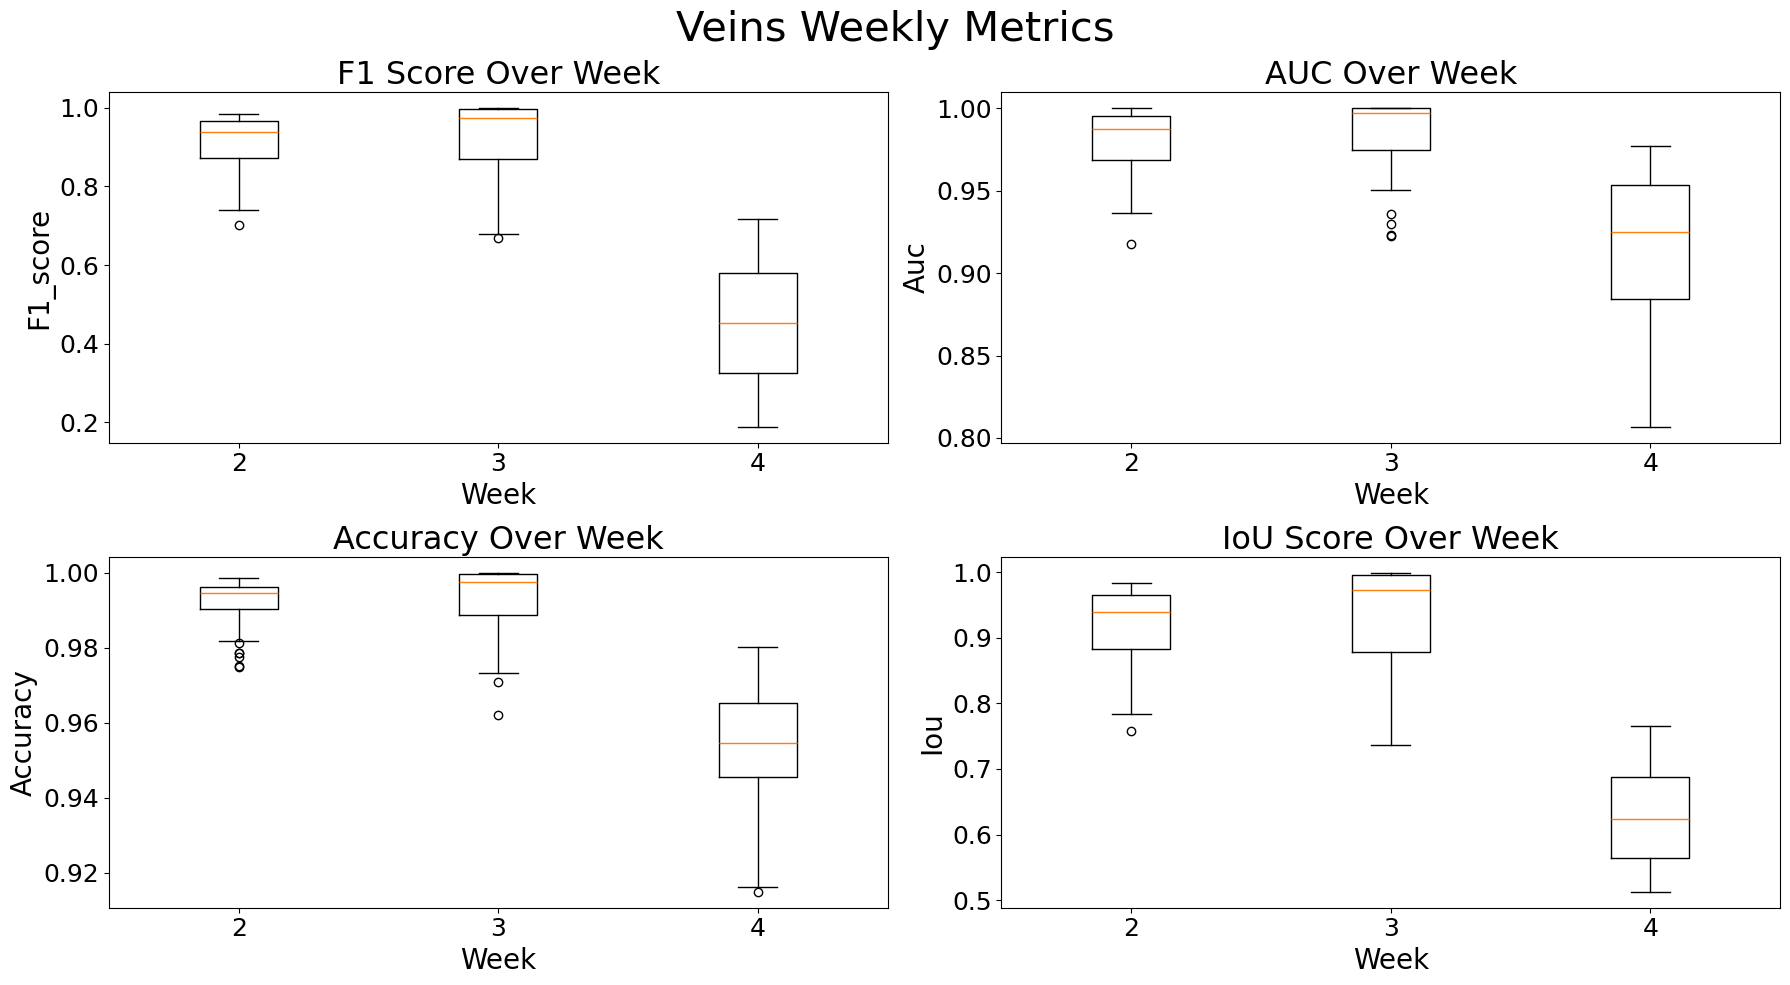

In [42]:
combined_df = combine_csv_files(SAVE_MODEL_DIR,"Veins_weekly_metrics.csv")


fig, axes = plt.subplots(2, 2, figsize=(18, 10))

plot_boxplot(axes[0][0], combined_df, 'f1_score', 'F1 Score Over Week')
plot_boxplot(axes[0][1], combined_df, 'AUC', 'AUC Over Week')
plot_boxplot(axes[1][0], combined_df, 'Accuracy', 'Accuracy Over Week')
plot_boxplot(axes[1][1], combined_df, 'IOU', 'IoU Score Over Week')

plt.suptitle('Veins Weekly Metrics', fontsize=30)
plt.tight_layout()

# Save and display 
save_metric_path = os.path.join(SAVE_VIZ_DIR,VERSION,"Veins_weekly_metrics_over_time.png")
plt.savefig(save_metric_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

# Miscellaneous


### misc

In [43]:
# def check_png_images_with_tensorflow(directory):
#     corrupted_images = []
#     for filename in os.listdir(directory):
#         if filename.endswith('.png'):
#             file_path = os.path.join(directory, filename)
#             try:
#                 image_data = tf.io.read_file(file_path)
#                 _ = tf.image.decode_png(image_data)  # Decode image
#             except (tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as e:
#                 print(f"Corrupted image found: {file_path}")
#                 corrupted_images.append(file_path)
    
#     if not corrupted_images:
#         print("All images are valid.")
#     else:
#         print(f"Corrupted images: {corrupted_images}")

# # Usage
# directory = '/path/to/png/images'
# check_png_images_with_tensorflow(IMG_AUG_DIR)
# check_png_images_with_tensorflow(AV_AUG_DIR)

In [44]:
# from PIL import Image

# def is_image_valid(file_path):
#     try:
#         img = Image.open(file_path)
#         img.verify()  # Verifies the image can be opened properly
#         return True
#     except Exception as e:
#         print(f"Corrupted image found: {file_path}. Error: {e}")
#         return False

In [45]:
veins_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "veins_best_pretrained_unet_av_100_epochs.keras")
arteries_model_path = os.path.join(SAVE_MODEL_DIR, VERSION, "arteries_best_pretrained_unet_av_100_epochs.keras")

arteries_mdl = keras.models.load_model(arteries_model_path, custom_objects={'f1_score': f1_score, 'iou_score':iou_score})
veins_mdl = keras.models.load_model(veins_model_path, custom_objects={'f1_score': f1_score, 'iou_score':iou_score})


In [46]:
veins_mdl.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, None, None, 1)  │    23,752,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,248,757 (271.79 MB)

 Trainable params: 23,748,241 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

 Optimizer params: 47,496,484 (181.18 MB)

In [47]:
# EYEPACS_DIR = '../data/RFI_Dataset/EYEPACS/'
# EYEPACS_DIR = os.path.join(EYEPACS_DIR, VERSION)
# IMG_AUG_DIR = os.path.join(EYEPACS_DIR, "train", "Original")
# AV_AUG_DIR = os.path.join(EYEPACS_DIR, "train", "AV_prediction")
# MAIN_DIR = '/Users/shawnpan/Downloads/Aditya_Kaggle_set2'  
# # Check if EYEPACS_DIR exists, if not, create it
# if not os.path.exists(EYEPACS_DIR):
#     os.makedirs(EYEPACS_DIR)
#     print(f"Created directory: {EYEPACS_DIR}")

# # Check if IMG_AUG_DIR exists, if not, create it
# if not os.path.exists(IMG_AUG_DIR):
#     os.makedirs(IMG_AUG_DIR)
#     print(f"Created directory: {IMG_AUG_DIR}")

# # Check if AV_AUG_DIR exists, if not, create it
# if not os.path.exists(AV_AUG_DIR):
#     os.makedirs(AV_AUG_DIR)
#     print(f"Created directory: {AV_AUG_DIR}")


# # Ensure target directories exist
# os.makedirs(IMG_AUG_DIR, exist_ok=True)
# os.makedirs(AV_AUG_DIR, exist_ok=True)


#     # Traverse through each subdirectory in MAIN_DIR
# for folder_name in os.listdir(MAIN_DIR):
#     folder_path = os.path.join(MAIN_DIR, folder_name)

#     # Check if it's a directory
#     if os.path.isdir(folder_path):
#         # Paths for the images we are looking for
#         input_image_path = os.path.join(folder_path, 'input_image.png')
#         segmentation_path = os.path.join(folder_path, 'Segmentation.png')
        
#         # Check if both images exist in the subdirectory
#         if os.path.exists(input_image_path) and os.path.exists(segmentation_path):
#             # Define new names based on folder name
#             new_input_name = f"{folder_name}.png"
#             new_segmentation_name = f"{folder_name}.png"
            
#             # Define destination paths
#             new_input_path = os.path.join(IMG_AUG_DIR, new_input_name)
#             new_segmentation_path = os.path.join(AV_AUG_DIR, new_segmentation_name)
            
#             # Copy and rename images
#             shutil.copy(input_image_path, new_input_path)
#             shutil.copy(segmentation_path, new_segmentation_path)
            
#             print(f"Copied {input_image_path} to {new_input_path}")
#             print(f"Copied {segmentation_path} to {new_segmentation_path}")
#         else:
#             print(f"Files not found in {folder_path}")

## Best Weights Metric

### Arteries

In [48]:
df = pd.read_json(os.path.join(SAVE_MODEL_DIR,VERSION,"arteries_history.json"))
df[df['val_iou_score'] == df['val_iou_score'].max()]

,auc,binary_accuracy,f1_score,iou_score,loss,val_auc,val_binary_accuracy,val_f1_score,val_iou_score,val_loss
25,0.941567,0.967973,0.460849,0.302377,0.089564,0.893848,0.963021,0.330411,0.198527,0.112325


### Veins

In [49]:
df = pd.read_json(os.path.join(SAVE_MODEL_DIR,VERSION,"veins_history.json"))
df[df['val_iou_score'] == df['val_iou_score'].max()]

,auc_1,binary_accuracy,f1_score,iou_score,loss,val_auc_1,val_binary_accuracy,val_f1_score,val_iou_score,val_loss
17,0.942717,0.957973,0.550039,0.383681,0.113516,0.906015,0.949122,0.43924,0.283186,0.13648


## Weekly Metric Mean Test Score

### Arteries

In [50]:
df = pd.read_csv(os.path.join(SAVE_MODEL_DIR,VERSION,"Arteries_weekly_metrics.csv"))
df.drop(columns=['Filename']).mean()

f1_score    0.303531
Accuracy    0.966112
AUC         0.890748
IOU         0.576986
week        4.000000
dtype: float64

### Veins

In [51]:
df = pd.read_csv(os.path.join(SAVE_MODEL_DIR,VERSION,"Veins_weekly_metrics.csv"))
df.drop(columns=['Filename']).mean()

f1_score    0.443740
Accuracy    0.953334
AUC         0.916564
IOU         0.624630
week        4.000000
dtype: float64

## Good Images

### Arteries

In [60]:
fp = os.path.join(SAVE_MODEL_DIR,VERSION,"Arteries_weekly_metrics.csv")
df = pd.read_csv(fp)
df.sort_values(by='IOU',ascending=False).head()

,Filename,f1_score,Accuracy,AUC,IOU,week
51,571_N.png,0.593016,0.966034,0.946556,0.693326,4
2,03_test.tif,0.543960,0.974396,0.972222,0.673794,4
45,22_A.png,0.544916,0.970722,0.944362,0.672345,4
77,555_N.png,0.522894,0.959972,0.946361,0.656537,4
9,10_test.tif,0.497720,0.975632,0.940360,0.653322,4


### Veins

In [61]:
fp = os.path.join(SAVE_MODEL_DIR,VERSION,"Veins_weekly_metrics.csv")
df = pd.read_csv(fp)
df.sort_values(by='IOU',ascending=False).head()

,Filename,f1_score,Accuracy,AUC,IOU,week
2,03_test.tif,0.717664,0.972813,0.976857,0.765747,4
3,04_test.tif,0.699342,0.973488,0.963711,0.755164,4
11,12_test.tif,0.676947,0.971550,0.970654,0.741166,4
4,05_test.tif,0.658072,0.973087,0.975080,0.731382,4
8,09_test.tif,0.641635,0.970909,0.960709,0.721245,4


## Worst Images

### Arteries

In [62]:
fp = os.path.join(SAVE_MODEL_DIR,VERSION,"Arteries_weekly_metrics.csv")
df = pd.read_csv(fp)
df.sort_values(by='IOU',ascending=True).head()


,Filename,f1_score,Accuracy,AUC,IOU,week
46,310_G.png,0.022499,0.971825,0.798271,0.491596,4
74,187_D.png,0.024277,0.976696,0.816728,0.494489,4
48,234_D.png,0.025657,0.976822,0.753481,0.494905,4
40,138_A.png,0.083970,0.959301,0.826766,0.501525,4
56,379_G.png,0.058154,0.980106,0.797756,0.505021,4


### Veins

In [63]:
fp = os.path.join(SAVE_MODEL_DIR,VERSION,"Veins_weekly_metrics.csv")
df = pd.read_csv(fp)
df.sort_values(by='IOU',ascending=True).head()

,Filename,f1_score,Accuracy,AUC,IOU,week
38,329_G.png,0.198194,0.916355,0.826165,0.512739,4
79,457_N.png,0.203395,0.914959,0.806769,0.513618,4
48,234_D.png,0.189019,0.943993,0.842636,0.523999,4
64,315_G.png,0.244596,0.918545,0.854947,0.528398,4
55,340_G.png,0.229233,0.930199,0.858681,0.529460,4
